In [1]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.

beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))


beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=0

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


tensor(0.2250, dtype=torch.float64)

tensor(0.2174, dtype=torch.float64)

tensor(0.2192, dtype=torch.float64)

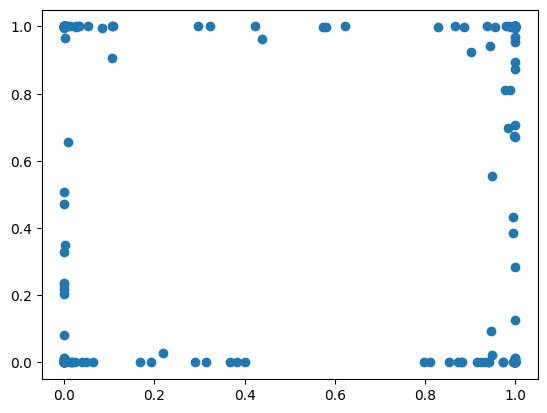

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)

plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()


tensor(0.2250, dtype=torch.float64)

tensor(0.2174, dtype=torch.float64)

tensor(0.2192, dtype=torch.float64)

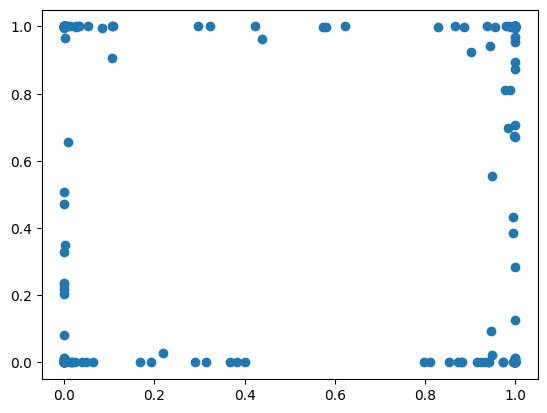

In [4]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

In [17]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [18]:
################## first step##################

#0.6,0.3
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)


    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr = config["lambda1"], config["lambda2"],config["lr"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
#         test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
#         test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
#         test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)


        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "lr":tune.choice([0.6,0.7,0.8])
    }
    #config={
    #    "lambda1": tune.choice([0.05,0.1,0.6]),
    #    "lambda2": tune.choice([0.0001,0.0002,0.0003, 0.0004,0.0005])
    #}

    result = tune.run(
        train_model,  
        config=config,
        num_samples=30)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_f8cf3_00000,TERMINATED,10.224.0.12:19777,0.04,0.003,0.8,1,13.483,0.890623
train_model_f8cf3_00001,TERMINATED,10.224.0.12:19826,0.03,0.002,0.8,1,14.138,0.878737
train_model_f8cf3_00002,TERMINATED,10.224.0.12:19829,0.03,0.003,0.6,1,14.5162,0.840777
train_model_f8cf3_00003,TERMINATED,10.224.0.12:19831,0.03,0.003,0.8,1,13.2892,0.87648
train_model_f8cf3_00004,TERMINATED,10.224.0.12:19833,0.03,0.003,0.8,1,16.2405,0.87648
train_model_f8cf3_00005,TERMINATED,10.224.0.12:19835,0.03,0.003,0.6,1,15.3372,0.840777
train_model_f8cf3_00006,TERMINATED,10.224.0.12:19837,0.03,0.001,0.8,1,14.7591,0.862552
train_model_f8cf3_00007,TERMINATED,10.224.0.12:19839,0.04,0.002,0.7,1,14.5914,0.888269
train_model_f8cf3_00008,TERMINATED,10.224.0.12:19841,0.03,0.003,0.7,1,14.8015,0.866059
train_model_f8cf3_00009,TERMINATED,10.224.0.12:19842,0.05,0.002,0.8,1,15.1382,0.910468


(raylet) [2022-11-13 21:49:27,625 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 294363136; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_f8cf3_00000:
  date: 2022-11-13_21-49-35
  done: false
  experiment_id: ae650019a01b4d178f0dc8a28d03c492
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8906232690231682
  node_ip: 10.224.0.12
  pid: 19777
  time_since_restore: 13.483023405075073
  time_this_iter_s: 13.483023405075073
  time_total_s: 13.483023405075073
  timestamp: 1668347375
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f8cf3_00000
  warmup_time: 0.003935575485229492
  
Result for train_model_f8cf3_00000:
  date: 2022-11-13_21-49-35
  done: true
  experiment_id: ae650019a01b4d178f0dc8a28d03c492
  experiment_tag: 0_lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8906232690231682
  node_ip: 10.224.0.12
  pid: 19777
  time_since_restore: 13.483023405075073
  time_this_iter_s: 13.483023405075073
  time_total_s: 13.483023405075073
  timestamp: 1668347375
  timesteps_since_r

(raylet) [2022-11-13 21:49:37,635 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 294191104; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_f8cf3_00027:
  date: 2022-11-13_21-49-37
  done: false
  experiment_id: b3a7dbd94acf41af8701b893ffa4d310
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8906232690231682
  node_ip: 10.224.0.12
  pid: 19878
  time_since_restore: 13.053869485855103
  time_this_iter_s: 13.053869485855103
  time_total_s: 13.053869485855103
  timestamp: 1668347377
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f8cf3_00027
  warmup_time: 0.004523038864135742
  
Result for train_model_f8cf3_00027:
  date: 2022-11-13_21-49-37
  done: true
  experiment_id: b3a7dbd94acf41af8701b893ffa4d310
  experiment_tag: 27_lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8906232690231682
  node_ip: 10.224.0.12
  pid: 19878
  time_since_restore: 13.053869485855103
  time_this_iter_s: 13.053869485855103
  time_total_s: 13.053869485855103
  timestamp: 1668347377
  timesteps_since_

Result for train_model_f8cf3_00001:
  date: 2022-11-13_21-49-38
  done: false
  experiment_id: 70415bc96a844caf994cee71ac82d4f8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8787367885246187
  node_ip: 10.224.0.12
  pid: 19826
  time_since_restore: 14.137969017028809
  time_this_iter_s: 14.137969017028809
  time_total_s: 14.137969017028809
  timestamp: 1668347378
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f8cf3_00001
  warmup_time: 0.04554343223571777
  
Result for train_model_f8cf3_00001:
  date: 2022-11-13_21-49-38
  done: true
  experiment_id: 70415bc96a844caf994cee71ac82d4f8
  experiment_tag: 1_lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8787367885246187
  node_ip: 10.224.0.12
  pid: 19826
  time_since_restore: 14.137969017028809
  time_this_iter_s: 14.137969017028809
  time_total_s: 14.137969017028809
  timestamp: 1668347378
  timesteps_since_re

Result for train_model_f8cf3_00008:
  date: 2022-11-13_21-49-39
  done: false
  experiment_id: 5a5c201d53aa4eb393fdb3c4a99f8883
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8660588604065224
  node_ip: 10.224.0.12
  pid: 19841
  time_since_restore: 14.801521062850952
  time_this_iter_s: 14.801521062850952
  time_total_s: 14.801521062850952
  timestamp: 1668347379
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f8cf3_00008
  warmup_time: 0.006079912185668945
  
Result for train_model_f8cf3_00008:
  date: 2022-11-13_21-49-39
  done: true
  experiment_id: 5a5c201d53aa4eb393fdb3c4a99f8883
  experiment_tag: 8_lambda1=0.0300,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8660588604065224
  node_ip: 10.224.0.12
  pid: 19841
  time_since_restore: 14.801521062850952
  time_this_iter_s: 14.801521062850952
  time_total_s: 14.801521062850952
  timestamp: 1668347379
  timesteps_since_r

2022-11-13 21:49:41,020	INFO tune.py:758 -- Total run time: 21.45 seconds (21.26 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
f8cf3_00000         0.890623         13.483023  True            None   
f8cf3_00001         0.878737         14.137969  True            None   
f8cf3_00002         0.840777         14.516196  True            None   
f8cf3_00003         0.876480         13.289244  True            None   
f8cf3_00004         0.876480         16.240529  True            None   
f8cf3_00005         0.840777         15.337195  True            None   
f8cf3_00006         0.862552         14.759055  True            None   
f8cf3_00007         0.888269         14.591399  True            None   
f8cf3_00008         0.866059         14.801521  True            None   
f8cf3_00009         0.910468         15.138240  True            None   
f8cf3_00010         0.825569         14.615229  True            None   
f8cf3_

(raylet) [2022-11-13 21:49:47,642 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 293527552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 21:49:57,650 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 293400576; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 21:50:07,659 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 293318656; capacity: 29394726912. Object creation will fail if spilling is required.


In [19]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final validation loss: 0.9104677649282212


{'lambda1': 0.05, 'lambda2': 0.002, 'lr': 0.8}

In [20]:
################## second step##################
################## training stage ##################

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


(raylet) [2022-11-13 21:50:17,667 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 293146624; capacity: 29394726912. Object creation will fail if spilling is required.


tensor(0.1592, grad_fn=<AddBackward0>)

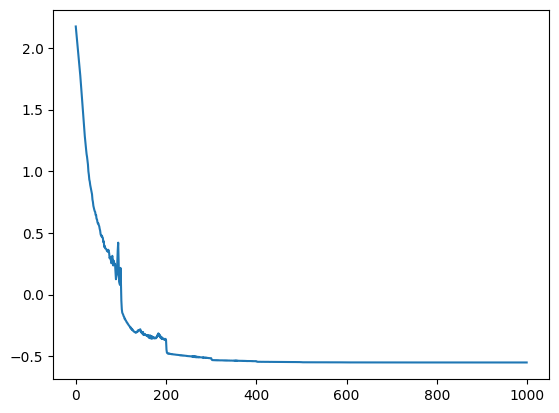

In [21]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [22]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.5028e-01, -1.3731e-01, -2.0366e-01, -1.2507e-01, -1.9510e-01,
         -1.3648e-01, -2.0588e-01, -1.1903e-01,  1.5501e-01,  2.5097e-01,
          2.4972e-06, -1.1378e-06,  3.2814e-06, -2.2565e-03,  1.6265e-06,
          1.0203e-06, -1.6754e-06,  1.9307e-06, -1.9834e-06, -2.8308e-06,
         -2.8474e-06,  2.4348e-06,  2.8235e-06, -8.6509e-04, -2.5632e-06,
         -2.9892e-06, -2.1101e-06,  2.9043e-06, -1.2857e-06, -1.6842e-06,
         -1.5224e-06, -2.9636e-06,  3.2438e-02, -2.9887e-06, -7.5678e-07,
          9.5157e-07,  4.5566e-07,  3.2339e-06, -4.5286e-08, -5.4124e-07,
          1.2746e-06,  3.3286e-06, -3.1434e-06,  2.0931e-06,  1.1325e-06,
          2.9533e-06, -1.7678e-06,  3.2673e-06,  3.5375e-06, -7.0774e-07,
         -3.1651e-06,  1.3459e-06, -3.1097e-06,  1.2881e-06, -1.8143e-06,
          2.1487e-02,  1.6318e-06,  5.4800e-07,  2.4785e-06,  3.4651e-07,
          2.5183e-02, -1.2920e-06, -4.5820e-02, -1.8333e-06, -2.3767e-06,
          1.7328e-06,  3.2324e-06, -3.

tensor([[-1.5028e-01, -1.3731e-01, -2.0366e-01, -1.2507e-01, -1.9510e-01,
         -1.3648e-01, -2.0588e-01, -1.1903e-01,  1.5501e-01,  2.5097e-01,
          2.4972e-06, -1.1378e-06,  3.2814e-06, -2.2565e-03,  1.6265e-06,
          1.0203e-06, -1.6754e-06,  1.9307e-06, -1.9834e-06, -2.8308e-06,
         -2.8474e-06,  2.4348e-06,  2.8235e-06, -8.6509e-04, -2.5632e-06,
         -2.9892e-06, -2.1101e-06,  2.9043e-06, -1.2857e-06, -1.6842e-06,
         -1.5224e-06, -2.9636e-06,  3.2438e-02, -2.9887e-06, -7.5678e-07,
          9.5157e-07,  4.5566e-07,  3.2339e-06, -4.5286e-08, -5.4124e-07,
          1.2746e-06,  3.3286e-06, -3.1434e-06,  2.0931e-06,  1.1325e-06,
          2.9533e-06, -1.7678e-06,  3.2673e-06,  3.5375e-06, -7.0774e-07,
         -3.1651e-06,  1.3459e-06, -3.1097e-06,  1.2881e-06, -1.8143e-06,
          2.1487e-02,  1.6318e-06,  5.4800e-07,  2.4785e-06,  3.4651e-07,
          2.5183e-02, -1.2920e-06, -4.5820e-02, -1.8333e-06, -2.3767e-06,
          1.7328e-06,  3.2324e-06, -3.

tensor([[-1.7603e-01, -1.7324e-01, -2.5180e-01, -1.7581e-01,  2.3373e-01,
         -1.6756e-01, -2.6717e-01, -1.5907e-01, -2.1813e-01, -3.0729e-01,
         -1.2905e-07, -4.6473e-08, -1.6915e-07,  2.6188e-02,  4.7549e-08,
          1.8211e-08, -1.1154e-07,  1.2175e-07,  9.5571e-07,  8.3295e-07,
         -9.2786e-08, -3.9797e-08, -6.8082e-08,  2.6916e-02,  9.5735e-08,
          8.5303e-09, -6.9631e-07,  6.1964e-07, -7.4973e-08, -3.0998e-07,
         -2.5851e-07, -1.1994e-07,  4.0214e-02,  5.2599e-08,  1.3569e-07,
         -2.1689e-06,  3.5337e-08, -4.8392e-08,  1.1186e-06, -3.1889e-07,
          1.0804e-07, -2.8922e-08,  9.5711e-08,  2.0028e-06,  1.4148e-06,
          2.3498e-08,  5.4030e-07, -1.2059e-07, -7.8325e-07,  4.4790e-08,
         -2.6217e-07,  1.9711e-09, -3.1018e-07,  2.9205e-07, -1.0015e-06,
          6.7551e-02,  2.0906e-07,  4.5991e-08,  9.4641e-08, -5.2413e-07,
          3.8965e-02,  5.8547e-08, -3.1572e-02, -1.6166e-07, -1.4604e-07,
         -1.5120e-06,  6.6680e-08, -1.

In [23]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[54,  9],
       [ 8, 49]])

0.8596491228070176

0.8571428571428571

0.8583333333333333

0.8448275862068966

0.8521739130434783

(raylet) [2022-11-13 21:50:27,674 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 293011456; capacity: 29394726912. Object creation will fail if spilling is required.


In [24]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[19,  3],
       [ 0, 18]])

1.0

0.8636363636363636

array([[17,  3],
       [ 7, 13]])

0.65

0.85

array([[18,  3],
       [ 1, 18]])

0.9473684210526315

0.8571428571428571

In [25]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.50279984e-01, -1.37313977e-01, -2.03660935e-01,
        -1.25071377e-01, -1.95101336e-01, -1.36483625e-01,
        -2.05877095e-01, -1.19028829e-01,  1.55011892e-01,
         2.50967175e-01,  2.49724349e-06, -1.13778492e-06,
         3.28136343e-06, -2.25650868e-03,  1.62652498e-06,
         1.02032368e-06, -1.67538496e-06,  1.93067649e-06,
        -1.98335124e-06, -2.83084773e-06, -2.84737803e-06,
         2.43480713e-06,  2.82351562e-06, -8.65086215e-04,
        -2.56322733e-06, -2.98917416e-06, -2.11007273e-06,
         2.90427715e-06, -1.28565705e-06, -1.68421172e-06,
        -1.52242012e-06, -2.96363510e-06,  3.24381217e-02,
        -2.98873965e-06, -7.56784289e-07,  9.51571280e-07,
         4.55661308e-07,  3.23391009e-06, -4.52861109e-08,
        -5.41243196e-07,  1.27463977e-06,  3.32860668e-06,
        -3.14335193e-06,  2.09305813e-06,  1.13251122e-06,
         2.95328095e-06, -1.76776416e-06,  3.26734744e-06,
         3.53746600e-06, -7.07738707e-07, -3.16507294e-0

array([[-1.50279984e-01, -1.37313977e-01, -2.03660935e-01,
        -1.25071377e-01, -1.95101336e-01, -1.36483625e-01,
        -2.05877095e-01, -1.19028829e-01,  1.55011892e-01,
         2.50967175e-01,  2.49724349e-06, -1.13778492e-06,
         3.28136343e-06, -2.25650868e-03,  1.62652498e-06,
         1.02032368e-06, -1.67538496e-06,  1.93067649e-06,
        -1.98335124e-06, -2.83084773e-06, -2.84737803e-06,
         2.43480713e-06,  2.82351562e-06, -8.65086215e-04,
        -2.56322733e-06, -2.98917416e-06, -2.11007273e-06,
         2.90427715e-06, -1.28565705e-06, -1.68421172e-06,
        -1.52242012e-06, -2.96363510e-06,  3.24381217e-02,
        -2.98873965e-06, -7.56784289e-07,  9.51571280e-07,
         4.55661308e-07,  3.23391009e-06, -4.52861109e-08,
        -5.41243196e-07,  1.27463977e-06,  3.32860668e-06,
        -3.14335193e-06,  2.09305813e-06,  1.13251122e-06,
         2.95328095e-06, -1.76776416e-06,  3.26734744e-06,
         3.53746600e-06, -7.07738707e-07, -3.16507294e-0

array([[-1.7603038e-01, -1.7324005e-01, -2.5180292e-01, -1.7580967e-01,
         2.3372951e-01, -1.6755885e-01, -2.6717019e-01, -1.5907145e-01,
        -2.1813077e-01, -3.0729175e-01, -1.2904721e-07, -4.6472671e-08,
        -1.6915271e-07,  2.6188359e-02,  4.7549197e-08,  1.8211475e-08,
        -1.1153873e-07,  1.2174858e-07,  9.5571147e-07,  8.3294782e-07,
        -9.2785811e-08, -3.9796735e-08, -6.8081533e-08,  2.6915761e-02,
         9.5734904e-08,  8.5303062e-09, -6.9631164e-07,  6.1963613e-07,
        -7.4972768e-08, -3.0997595e-07, -2.5850639e-07, -1.1994089e-07,
         4.0213875e-02,  5.2598505e-08,  1.3569210e-07, -2.1688711e-06,
         3.5337489e-08, -4.8392462e-08,  1.1186238e-06, -3.1888609e-07,
         1.0803526e-07, -2.8922118e-08,  9.5710924e-08,  2.0028192e-06,
         1.4147544e-06,  2.3498034e-08,  5.4030465e-07, -1.2058813e-07,
        -7.8325360e-07,  4.4790326e-08, -2.6216853e-07,  1.9710817e-09,
        -3.1018092e-07,  2.9204793e-07, -1.0015132e-06,  6.75507

In [26]:
threshold=0.12
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.15027998, -0.13731398, -0.20366094, -0.12507138, -0.19510134,
        -0.13648362, -0.2058771 , -0.11902883,  0.15501189,  0.25096717,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.03243812,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.04581986,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 33, 63, 88, 93])

14

In [27]:
index=np.nonzero(model_1_weight)[1]
index=index.tolist()
index=set(index)

beta=np.array(beta_1)
trueindex=np.where(beta!=0)[0]
trueindex=trueindex.tolist()
trueindex=set(trueindex)

TP=len(trueindex.intersection(index))
FP=len(index.difference(trueindex))
FN=len(trueindex)-TP
TN=p-len(trueindex)-FP
vsSEN=TP/(TP+FN)#vsSEN.
vsSPE=TN/(TN+FP)#vsSPE
vsSEN
vsSPE
math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP+FN)/(TP+FN+TN+FP)#vsMR
1-vsMR#vsCCR

1.0

0.9555555555555556

0.9775252199076787

0.96

(raylet) [2022-11-13 21:50:37,695 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 292884480; capacity: 29394726912. Object creation will fail if spilling is required.


In [28]:
FP
index
trueindex

4

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 32, 62, 87, 92}

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

(raylet) [2022-11-13 21:50:47,703 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 292896768; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 21:50:57,711 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 292773888; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 21:51:07,720 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 292691968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 21:51:17,728 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 294965248; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 21:55:57,959 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 315183104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 21:56:07,965 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 315105280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 21:56:17,972 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 313585664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 21:56:27,980 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 313167872; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 22:01:08,214 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 309104640; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:01:18,222 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 308944896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:01:28,231 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 308834304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:01:38,240 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 308682752; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 22:06:18,479 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 305434624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:06:28,487 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 305324032; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:06:38,496 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 305168384; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:06:48,505 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 305090560; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 22:11:28,745 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 301862912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:11:38,754 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 301719552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:11:48,762 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 300470272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:11:58,770 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 302891008; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 22:16:39,041 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 402309120; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:16:49,049 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 402092032; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:16:59,058 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 401068032; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:17:09,064 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 400044032; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 22:21:49,284 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 373260288; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:21:59,292 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 372813824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:22:09,299 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 371666944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:22:19,307 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 370823168; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 22:26:59,600 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 343502848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:27:09,607 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 343150592; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:27:19,613 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 341151744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 22:27:29,620 E 17820 17845] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_21-48-15_551800_17701 is over 95% full, available space: 340426752; capacity: 29394726912. Object creation will fail i